# Compute $R^\prime_{HK}$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
from astropy.time import Time
from astropy.io import ascii

from toolkit import (json_to_stars, Measurement, stars_to_json, FitParameter,
                     parse_hires, StarProps)

props = dict(fontsize=15)

hat11 = json_to_stars('hat11.json')

f = FitParameter.from_text('calibrated_f.txt')
c1 = FitParameter.from_text('calibrated_c1.txt')
c2 = FitParameter.from_text('calibrated_c2.txt')

hat11_s_apo = Measurement([s.s_apo.uncalibrated.value for s in hat11],
                          err=[s.s_apo.uncalibrated.err for s in hat11],
                          time=[s.s_apo.time.jd for s in hat11])

##############################################################################
# Solve for HAT-P-11 S-indices:
hat11_s_mwo_err = np.sqrt((f.value * hat11_s_apo.value * c1.err_lower)**2 +
                          (c1.value * f.value * hat11_s_apo.err)**2 +
                          c2.err_lower**2)

hat11_s_mwo = Measurement(c1.value * hat11_s_apo.value + c2.value,
                          err=hat11_s_mwo_err,
                          time=hat11_s_apo.time)

hat11_apo_calibrated = [StarProps(name='HAT-P-11', s_apo=sapo, s_mwo=smwo,
                                  time=sapo.time)
                        for sapo, smwo in zip(hat11_s_apo, hat11_s_mwo)]

stars_to_json(hat11_apo_calibrated, 'hat11_apo_calibrated.json')

#############################################################################
# Plot the S-index time series for HAT-P-11 with HIRES data too
hires = parse_hires('hat-p-11_svals.txt')

# hat11_s_mwo_mean = c1.value * hat11_s_apo.value.mean() + c2.value
# hat11_s_apo_err_mean = np.sqrt(np.sum(hat11_s_apo.err**2/len(hat11_s_apo.err)**2))
# hat11_s_mwo_mean_err = np.sqrt((hat11_s_apo.value.mean() * c1.err_lower)**2 +
#                                (c1.value * hat11_s_apo_err_mean)**2 +
#                                c2.err_lower**2)

last_week_inds = np.argsort(hat11_s_apo.time.jd)[-8:]
hat11_s_mwo_mean = c1.value * hat11_s_apo.value[last_week_inds].mean() + c2.value
hat11_s_apo_err_mean = np.sqrt(np.sum(hat11_s_apo.err[last_week_inds]**2 /
                                      len(last_week_inds)**2))
hat11_s_mwo_mean_err = np.sqrt((hat11_s_apo.value[last_week_inds].mean() * c1.err_lower)**2 +
                               (c1.value * hat11_s_apo_err_mean)**2 +
                               c2.err_lower**2)


rm = (hires['time'].decimalyear < 2010.7) & (hires['time'].decimalyear > 2010.6)
rough_hires_err = np.std(hires[rm]['S-value'])

hat11_s_keck = Measurement(value=hires['S-value'].data,
                           err=rough_hires_err * np.ones(len(hires['S-value'].data)),
                           time=hires['time'])

hat11_keck_calibrated = [StarProps(name='HAT-P-11', s_mwo=s, time=s.time)
                         for s in hat11_s_keck]

times = np.hstack([hires['time'].decimalyear, hat11_s_apo.time.decimalyear])
sind = np.hstack([hires['S-value'], hat11_s_mwo.value])
sind_err = np.hstack([rough_hires_err * np.ones(len(hires['S-value'].data)), hat11_s_mwo.err])

In [19]:
s_mean_h11 = np.mean(sind)

#from astropy.constants import sigma_sb
sigma_sb = 5.67051e-5 # http://www.astro.wisc.edu/~dolan/constants.html
import astropy.units as u

def c_cf(b_minus_v):
    # Mittag 2013, eq. 7 (main sequence):
    return 10**(0.25*b_minus_v**3 - 1.33*b_minus_v**2 + 0.43*b_minus_v + 0.24 )

alpha_apo = np.loadtxt('calibrated_c1.txt')[0]
alpha_mwo = 19.2

def scriptf_hk(s, b_minus_v, t_eff, alpha_ratio=1): #alpha_mwo/alpha_apo):
    # Mittag 2013
    K = 10**(6.086 - 0.2088*b_minus_v + 0.3564*b_minus_v**2 - 0.002*b_minus_v**3) / alpha_ratio # Eqn. 12
    F_hk = c_cf(b_minus_v) * t_eff**4 * 1e-14 * s # eqn 9
    return K * F_hk # eqn 10

def scriptf_hkphot(b_minus_v):
    # Mittag 2013 eqn 20:
    return 10**(7.49 - 2.06 * b_minus_v)

def rprime_hk(s, b_minus_v, t_eff):
    # Mittag 2013 eqn 24
    return (scriptf_hk(s, b_minus_v, t_eff) - scriptf_hkphot(b_minus_v)) / (sigma_sb * t_eff**4)

def log_rprime_hk(s, b_minus_v, t_eff):
    return np.log10(rprime_hk(s, b_minus_v, t_eff))

# t_eff = 4750
# b_minus_v = 1.19

# #rprime_h11 = c_cf(b_minus_v) * s_mean_h11 - f_hkphot(b_minus_v) / (sigma_sb * t_eff**4).value

# log_rprime_hk(s_mean_h11, b_minus_v, t_eff)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


[<matplotlib.text.Text at 0x1187bbc88>, <matplotlib.text.Text at 0x117dc2ef0>]

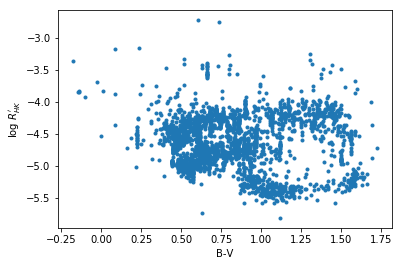

In [20]:
from toolkit import get_duncan_catalog

table = get_duncan_catalog()

b_minus_v = (table['Bmag'] - table['Vmag']).data
t_eff = 10**(3.981 - 0.4728*b_minus_v + 0.2434*b_minus_v**2 - 0.0620*b_minus_v**3) # Mittag eqn. 3
s = table['Smean'].data

logrprime = log_rprime_hk(s, b_minus_v, t_eff)

fig, ax = plt.subplots()
ax.plot(b_minus_v, logrprime, '.')
ax.set(xlabel='B-V', ylabel='log $R^\prime_{HK}$')

In [21]:
log_rprime_hk(s_mean_h11, 1.19, 4750)

-4.4011687977915646

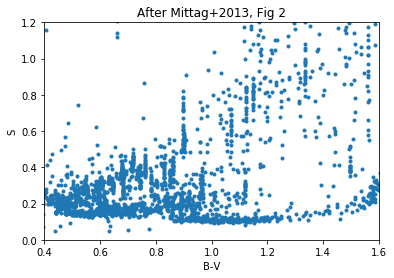

In [22]:
plt.plot(b_minus_v, table['Smean'], '.')
plt.ylim([0, 1.2])
plt.xlim([0.4, 1.6])
plt.title('After Mittag+2013, Fig 2')
plt.xlabel('B-V')
plt.ylabel('S')

Must cross-match targets against Hipparcos table: `I/239/hip_main`

In [142]:
with open('duncan_targets.txt', 'w') as w:
    w.write('\n'.join(map(lambda x: "{0:s}".format(x.decode()), np.unique(table['SName'].data.data))))

Absolute magnitude $M_V$ from apparent mag $m_V$:
$$M_V=m_V-5\left(\log _{10}d-1\right)$$

where $d$ is distance in parsec which can be computed from parallax with: 

$$d = \frac{1}{\textrm{parallax half-angle in arcsec}}$$

In [299]:
hipp1 = ascii.read('duncan_hipparcos_crossmatch.tsv', header_start=0, data_start=56, delimiter='\t')

#from astropy.table import vstack
#hipp = vstack([hipp1, hipp2])


/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


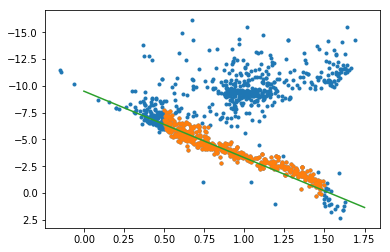

In [300]:
#hipp = ascii.read('duncan_hipparcos_crossmatch.tsv', header_start=0, data_start=56, delimiter='\t')
hipp1['_1'] = Column([line.strip() for line in hipp1['_1'].data.data], "_1")
hipp1.add_index('_1')

parallax_arcsec = (hipp1['Plx']/1000)
dist_pc = 1./parallax_arcsec
M_V = hipp1['Vmag'] - 5*(np.log10(dist_pc) + 1)

x = np.linspace(0, 1.75)
def color_cut(b_minus_v):
    return -9.5 + 6.2*b_minus_v

main_sequence = (np.abs(M_V - color_cut(hipp1['B-V'])) < 1.5) & (hipp1['B-V'] > 0.5) & (hipp1['B-V'] < 1.5)

y = color_cut(x)
from astropy.table import Column
hipp1.add_column(Column(main_sequence, 'MS'))

fig, ax = plt.subplots()
ax.plot(hipp1['B-V'], M_V, '.')
ax.plot(hipp1['B-V'][main_sequence], M_V[main_sequence], '.')
ax.plot(x, y)
ax.invert_yaxis();

In [301]:
main_sequence_ids = []
mwo_target_names = list(map(lambda x: "{0:s}".format(x.decode()), table['SName'].data.data))
for mwo_target in mwo_target_names:
    if mwo_target in hipp1['_1'].data.data:
        if not hasattr(hipp1.loc[mwo_target]['MS'], '__len__'):
            main_sequence_ids.append(hipp1.loc[mwo_target]['MS'])
        else: 
            main_sequence_ids.append(hipp1.loc[mwo_target]['MS'][0])
    else: 
        main_sequence_ids.append(False)

if 'MS' not in table.colnames:
    table.add_column(Column(main_sequence_ids, 'MS'))
else: 
    table['MS'] = Column(main_sequence_ids, 'MS')

[<matplotlib.text.Text at 0x120546c18>, <matplotlib.text.Text at 0x12056c630>]

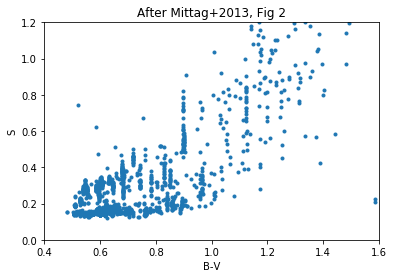

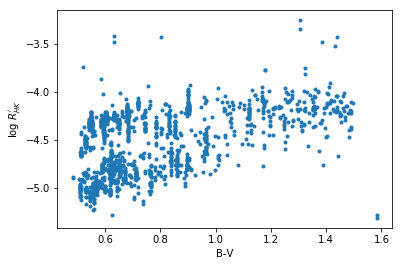

In [302]:
b_minus_v_ms = (table['Bmag'] - table['Vmag']).data[table['MS']]
t_eff_ms = 10**(3.981 - 0.4728*b_minus_v_ms + 0.2434*b_minus_v_ms**2 - 0.0620*b_minus_v_ms**3) # Mittag eqn. 3
s_ms = table['Smean'].data[table['MS']]

plt.plot(b_minus_v_ms, s_ms, '.')
plt.ylim([0, 1.2])
plt.xlim([0.4, 1.6])
plt.title('After Mittag+2013, Fig 2')
plt.xlabel('B-V')
plt.ylabel('S')

logrprime_ms = log_rprime_hk(s_ms, b_minus_v_ms, t_eff_ms)

fig, ax = plt.subplots()
ax.plot(b_minus_v_ms, logrprime_ms, '.')
ax.set(xlabel='B-V', ylabel='log $R^\prime_{HK}$')

In [192]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = 1e10   # Otherwise would only show first 50 values
wright = Vizier.get_catalogs('J/ApJS/152/261/table1')[0]

with open('wright_targets.txt', 'w') as w:
    w.write('\n'.join(map(lambda x: "{0:s}".format(x.decode()), np.unique(wright['SimbadName'].data.data))))

In [270]:
hipp2 = ascii.read('wright_hipparcos_crossmatch.tsv', header_start=0, data_start=56, delimiter='\t')
hipp2['_1'] = Column([line.strip() for line in hipp2['_1'].data.data], "_1")
hipp2.add_index('_1')
hipp2['B-V'] = Column(np.array(list(map(lambda x: float(x) if len(x.strip()) > 1 else 0, hipp2['B-V'].data))), 'B-V')

In [272]:
wright_grouped = wright.group_by('SimbadName').groups.aggregate(np.mean)
wright_grouped.add_index('SimbadName')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


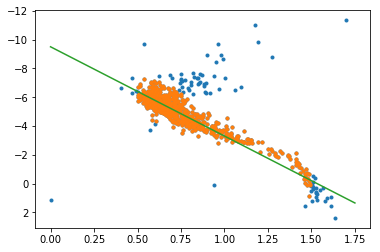

In [277]:
#hipp = ascii.read('duncan_hipparcos_crossmatch.tsv', header_start=0, data_start=56, delimiter='\t')
parallax_arcsec = (hipp2['Plx']/1000)
dist_pc = 1./parallax_arcsec
M_V = hipp2['Vmag'] - 5*(np.log10(dist_pc) + 1)

x = np.linspace(0, 1.75)
def color_cut(b_minus_v):
    return -9.5 + 6.2*b_minus_v

main_sequence = (np.abs(M_V - color_cut(hipp2['B-V'])) < 1.5) & (hipp2['B-V'] > 0.5) & (hipp2['B-V'] < 1.5)

y = color_cut(x)
from astropy.table import Column
hipp2.add_column(Column(main_sequence, 'MS'))

fig, ax = plt.subplots()
ax.plot(hipp2['B-V'], M_V, '.')
ax.plot(hipp2['B-V'][main_sequence], M_V[main_sequence], '.')
ax.plot(x, y)
ax.invert_yaxis();

[<matplotlib.text.Text at 0x120de9668>, <matplotlib.text.Text at 0x120e7af98>]

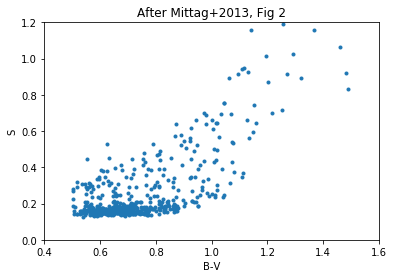

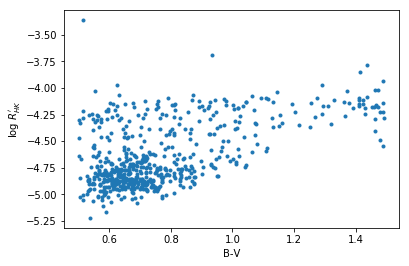

In [298]:
main_sequence_ids = []
b_minus_v_wright = []
mwo_target_names = list(map(lambda x: "{0:s}".format(x.decode()), wright_grouped['SimbadName'].data.data))
for mwo_target in mwo_target_names:
    if mwo_target in hipp2['_1'].data.data:
        if not hasattr(hipp2.loc[mwo_target]['MS'], '__len__'):
            main_sequence_ids.append(hipp2.loc[mwo_target]['MS'])
            b_minus_v_wright.append(hipp2.loc[mwo_target]['B-V'])
        else: 
            main_sequence_ids.append(hipp2.loc[mwo_target]['MS'][0])
            b_minus_v_wright.append(0)
    else: 
        main_sequence_ids.append(False)
        b_minus_v_wright.append(0)

if 'MS' not in wright_grouped.colnames:
    wright_grouped.add_column(Column(main_sequence_ids, 'MS'))
else: 
    wright_grouped['MS'] = Column(main_sequence_ids, 'MS')

if 'B-V' not in wright_grouped.colnames:
    wright_grouped.add_column(Column(b_minus_v_wright, 'B-V'))
else: 
    wright_grouped['B-V'] = b_minus_v_wright

b_minus_v_ms_w = wright_grouped['B-V'].data[wright_grouped['MS']]
t_eff_ms_w = 10**(3.981 - 0.4728*b_minus_v_ms_w + 0.2434*b_minus_v_ms_w**2 - 0.0620*b_minus_v_ms_w**3) # Mittag eqn. 3
s_ms_w = wright_grouped['Sdiff'].data[wright_grouped['MS']]

plt.plot(b_minus_v_ms_w, s_ms_w, '.')
plt.ylim([0, 1.2])
plt.xlim([0.4, 1.6])
plt.title('After Mittag+2013, Fig 2')
plt.xlabel('B-V')
plt.ylabel('S')

logrprime_ms_w = log_rprime_hk(s_ms_w, b_minus_v_ms_w, t_eff_ms_w)

fig, ax = plt.subplots()
ax.plot(b_minus_v_ms_w, logrprime_ms_w, '.')
ax.set(xlabel='B-V', ylabel='log $R^\prime_{HK}$')

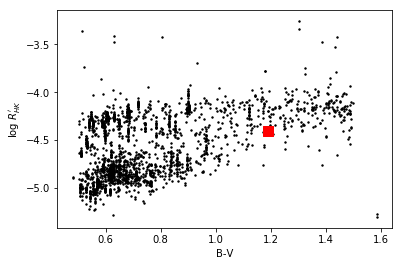

In [333]:
fig, ax = plt.subplots()
ax.scatter(b_minus_v_ms_w, logrprime_ms_w, marker='.', color='k', s=8)
ax.scatter(b_minus_v_ms, logrprime_ms, marker='.', color='k', s=8)

logrprime_h11 = log_rprime_hk(s_mean_h11, 1.19, 4750)
ax.scatter(1.19, logrprime_h11, marker='s', color='r', s=100)

ax.set(xlabel='B-V', ylabel='log $R^\prime_{HK}$')
plt.savefig('plots/rprime.png', bbox_inches='tight', dpi=200)